In [298]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [299]:
def show_image(window_name, image, cmap=None):
    if image is None:
        print(f"{window_name}: imagem nao carregada (None)")
        return

    if len(image.shape) == 3 and image.shape[2] == 3:
        img_disp = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        img_disp = image
        if cmap is None:
            cmap = 'gray'
    plt.figure(figsize=(8, 6))
    plt.title(window_name)
    plt.axis('off')
    plt.imshow(img_disp, cmap=cmap)
    plt.show()

def close_all_windows():
    pass

In [300]:
MIN_AREA = 400
MAX_AREA = 1200

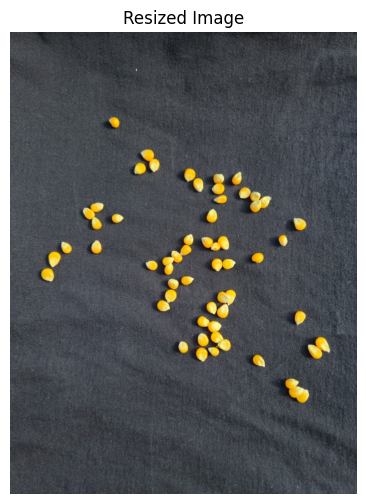

In [ ]:
img = cv2.imread('imagens/agrupado3.jpg')
craped_img = img.copy()
# img = cv2.resize(img, (600, 800))
show_image("Resized Image", img)

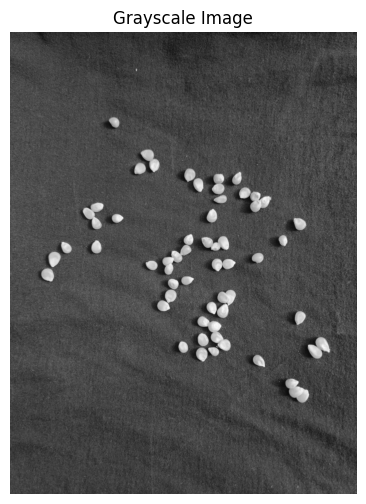

In [302]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_image("Grayscale Image", gray)

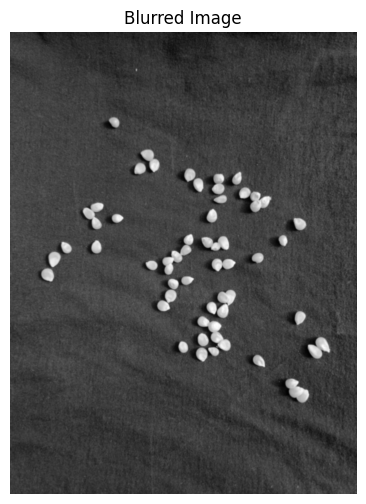

In [303]:
blur = cv2.GaussianBlur(gray, (5, 5), 0)
show_image("Blurred Image", blur)

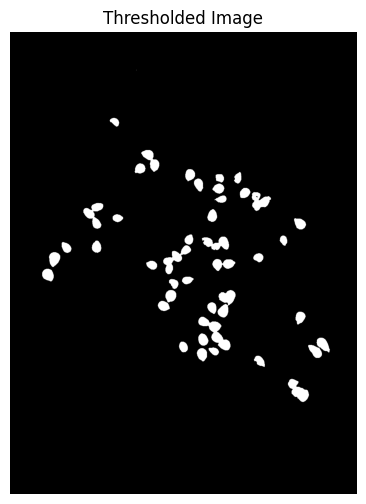

In [304]:
_, thresh = cv2.threshold(blur, 165, 255, cv2.THRESH_BINARY)
show_image("Thresholded Image", thresh)

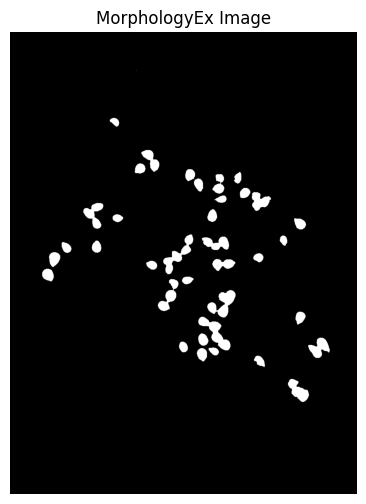

In [305]:
morphologyEx = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

show_image("MorphologyEx Image", morphologyEx)

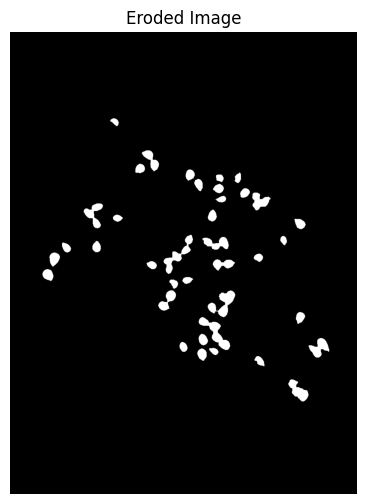

In [306]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
eroded = cv2.erode(morphologyEx, kernel, iterations=1)

show_image("Eroded Image", eroded)

In [307]:
contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# for i, c in enumerate(contours):
#     x, y, w, h = cv2.boundingRect(c)
#     cv2.putText(img, f"{i+1}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
#     cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
# print("Objetos detectados:", len(contours))
# show_image("Detected Objects", img)

In [308]:
average_area = 0
new_contours = []
count_valid = 0
for i, c in enumerate(contours):
    x, y, w, h = cv2.boundingRect(c)
    area = w * h
    if area < MIN_AREA or area > MAX_AREA:
        continue
    average_area += area
    new_contours.append(c)
    count_valid += 1

average_area /= count_valid if count_valid else 1
MIN_AVERAGE_AREA = average_area * 0.75
MAX_AVERAGE_AREA = average_area * 1.75

In [309]:
def classify_grain(grain_img, contour_area):
    if contour_area < MIN_AVERAGE_AREA:
        return "small", "area too small (noise)"

    if contour_area > MAX_AVERAGE_AREA:
        return "bad_detection", "area too large (probably multiple grains)"

    hsv = cv2.cvtColor(grain_img, cv2.COLOR_BGR2HSV)

    h_mean = np.mean(hsv[:, :, 0])
    s_mean = np.mean(hsv[:, :, 1])
    v_mean = np.mean(hsv[:, :, 2])

    if v_mean < 90 and s_mean < 60:
        return "burned", f"dark grain (H={h_mean:.1f}, S={s_mean:.1f}, V={v_mean:.1f})"

    if 40 <= h_mean <= 80:
        return "greenish", f"green hue (H={h_mean:.1f})"

    if 18 <= h_mean <= 35 and v_mean > 100:
        return "good", f"healthy yellow grain (H={h_mean:.1f})"

    return "unknown", f"undefined color pattern (H={h_mean:.1f})"

Parametros de área média: 
Área média: 703.52
MIN_AVERAGE_AREA: 527.64
MAX_AVERAGE_AREA: 1231.16

Objeto 1: x=770, y=962, w=56, h=62, area=3472
Classificação: bad_detection (area too large (probably multiple grains))

Objeto 2: x=676, y=898, w=28, h=28, area=784
Classificação: good (healthy yellow grain (H=27.5))

Objeto 3: x=518, y=877, w=26, h=34, area=884
Classificação: good (healthy yellow grain (H=25.9))

Objeto 4: x=551, y=875, w=26, h=20, area=520
Classificação: small (area too small (noise))

Objeto 5: x=469, y=859, w=22, h=27, area=594
Classificação: good (healthy yellow grain (H=25.3))

Objeto 6: x=826, y=848, w=58, h=54, area=3132
Classificação: bad_detection (area too large (probably multiple grains))

Objeto 7: x=522, y=836, w=26, h=32, area=832
Classificação: good (healthy yellow grain (H=24.9))

Objeto 8: x=522, y=790, w=87, h=91, area=7917
Classificação: bad_detection (area too large (probably multiple grains))

Objeto 9: x=791, y=776, w=26, h=33, area=858
Classificação

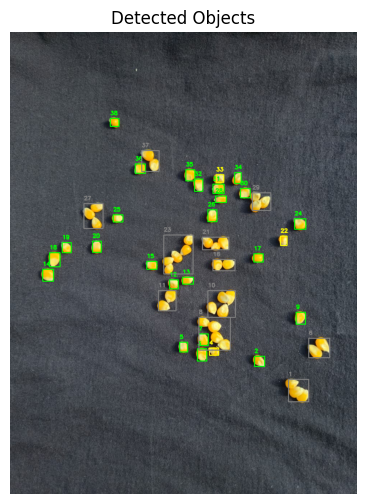

Resumo da classificação dos grãos:
good: 24
burned: 0
greenish: 0
bad_detection: 11
small: 3
unknown: 0


In [310]:
grains = {
    'good': 0,
    'burned': 0,
    'greenish': 0,
    'bad_detection': 0,
    'small': 0,
    'unknown': 0
}

colors = {
    'good': (0, 255, 0),
    'burned': (0, 0, 255),
    'greenish': (255, 255, 0),
    'bad_detection': (128, 128, 128),
    'small': (0, 255, 255),
    'unknown': (255, 0, 255)
}

print("Parametros de área média: ")
print(f"Área média: {average_area:.2f}")
print(f"MIN_AVERAGE_AREA: {MIN_AVERAGE_AREA:.2f}")
print(f"MAX_AVERAGE_AREA: {MAX_AVERAGE_AREA:.2f}\n")

for i, c in enumerate(contours):
    x, y, w, h = cv2.boundingRect(c)
    grain = craped_img[y:y+h, x:x+w]
    
    hsv = cv2.cvtColor(grain, cv2.COLOR_BGR2HSV)
    h_mean = np.mean(hsv[:, :, 0])
    s_mean = np.mean(hsv[:, :, 1])
    v_mean = np.mean(hsv[:, :, 2])
    area = w * h
    
    classification, reason = classify_grain(grain, area)
    grains[classification] += 1
    print(f"Objeto {i+1}: x={x}, y={y}, w={w}, h={h}, area={w*h}")
    # print(f"Média HSV: H={h_mean:.2f}, S={s_mean:.2f}, V={v_mean:.2f}")
    print(f"Classificação: {classification} ({reason})\n")
    # show_image(f"Objeto {i+1}", grain)

    cv2.putText(img, f"{i+1}", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[classification], 2)
    cv2.rectangle(img, (x, y), (x+w, y+h), colors[classification], 2)

show_image("Detected Objects", img)
print("Resumo da classificação dos grãos:")
for category, count in grains.items():
    print(f"{category}: {count}")